<h1><center>Analysis of Covid and related policy data in the United States</center></h1>
<h3><center>Shangyu Lai</center></h3>

## 1 introduction
It is the end of 2021, but unfortunately the pandemic of COVID-19 has not yet ended. Even worse, the virus is still mutating and spreading. Especially, the Omicron mutaion is discovered and the virus could spread faster than ever. The vaccine is not that effective for the Omicron mutation. In this situation, personal effort is not enough to prevent the virus from spreading. Impact of governments is strongly needed to control the pandemic. In this tutorial, I will analyze the data of the government policies and the data of the COVID-19. I will try to answer the following questions:
1. How to define strigency of the policies?
2. How the strigenties of the policies are related to the COVID-19?
3. How to visualize the data to show the relationship between the policies and the COVID-19?

## 2 Data collection and description
I collect all the data from the following github reposities or links. All the data I used was updated in Dec 11th, 2021. 

#### 2.1 Vaccinations data:
Vaccinations data is from the CDC, <a href="https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh">COVID-19 Vaccinations in the United States,County</a>. From this dataset we can know the number of people from each county who have been vaccinated for the COVID-19. The data includes vaccination date, recipents state and county, and number of people who have been fully vaccinated, etc.. The format of date is MM/DD/YYYY.

#### 2.2 Policy and covid data: 
Policy data is from <a href="https://github.com/OxCGRT/covid-policy-tracker">covid-policy-tracker</a>. Some basic information about COVID-19 like total cases and deaths are embeded in this dataset (Covid data is from <a href="https://github.com/CSSEGISandData/COVID-19">COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins UniversityJohns Hopkins University Center for Systems Science and Engineering (JHU CSSE) </a>). In this dataset it defines strigency $SI=\frac{1}{9}(\sum\limits_{j=1}^{8}{Cj}+H1)$. From $C1$ to $C8$, the meaning of each number is as follows: 

| ID | Description |
| --- | --- |
|<p><center> $C1$</p> | Record closings of schools and universitiesTotal cases |
|<p><center> $C2$</p> | Record closings of workplaces |
|<p><center> $C3$</p> | Record cancelling public events |
|<p><center> $C4$</p> | Record limits on gatherings |
|<p><center> $C5$</p> | Record closing of public transport |
|<p><center> $C6$</p> | Record orders to "shelter-in-place" and otherwise confine to the home |
|<p><center> $C7$</p> | Record restrictions on internal movement between cities/regions |
|<p><center> $C8$</p> | Record restrictions on international travel |
|<p><center> $H1$</p> | Record restrictions on gatherings |

For more details about the data, please refer to the <a href="https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md">codebook</a>.

#### 2.3 timeline: 
I get information about the timeline from <a href="https://www.cdc.gov/museum/timeline/covid19.html">CDC</a>. The timeline is from Dec 12, 2019 to Apr 23, 2021.
By this data, I can roughly know what happened during the pandemic. It may provide some useful information to understand how Covid and policies are impacted by each other.


In [1]:
import pandas as pd
import numpy as np
import contextily as cx
import requests
from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
import pandas_alive
import geopandas
import warnings
warnings.filterwarnings('ignore')
# read data
vaccine_data = pd.read_csv('covid/COVID-19_Vaccinations_in_the_United_States_County.csv')
vaccine_data = vaccine_data[['Date','Recip_State','Series_Complete_Yes']]

covid_data_US = pd.read_csv('covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
covid_data_US_deaths = pd.read_csv('covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
covid_data_US = covid_data_US.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2'])
covid_data_US_deaths = covid_data_US_deaths.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2'])

covid_data_Global = pd.read_csv('covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covid_data_Global_deaths = pd.read_csv('covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
covid_data_Global_recovered = pd.read_csv('covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

policy_data_2020 = pd.read_csv('covid/covid-policy-tracker/data/OxCGRT_withnotes_2020.csv',low_memory=False)
policy_data_2021 = pd.read_csv('covid/covid-policy-tracker/data/OxCGRT_withnotes_2021.csv',low_memory=False)
policy_data = policy_data_2020.append(policy_data_2021)
policy_data = policy_data.drop(columns=['M1_Wildcard'])
del policy_data_2020, policy_data_2021

# timeline data
r = requests.get('https://www.cdc.gov/museum/timeline/covid19.html')
timeline = bs(r.content, 'html.parser').find_all('div', class_='card-body')

## 3 Data Processing
For the first step, I want to visualize the data to show the relationship between the policies and the COVID-19. Then we can get a rough answer for the following questions:

1. How Covid-19 progress in the US?
2. How strigency changes with time?
3. Any relationship between the policies and the spread of Covid-19?
4. Any relationship between the policies and the death rate?
5. Any relationship between the policies and the number of cases?
6. Any relationship between the policies and the number of vaccinations?

I want to merge the vaccination data with the polycy data so that I only need to process one dataframe. I will use the following steps to do this:
* Filtering the policy data to get the data of the US.
* Using RegionCode column in the policy data to represent states in the US. Since we also need to the whole US data, I fill the NaN values in the RegionCode column with 'US', which represents the summary of all the states.
* In the vaccine data it only has county level data, I need to sum the data of each county in the same state and then sum the data of each state to get the data of the whole US.
* Changing date in to datetime format.
* Setting the index to date.

In [2]:
policy_data_US_states = policy_data[policy_data['CountryCode'] == 'USA']
# policy_data_US_states = policy_data_US_states[policy_data_US_states['RegionCode'].notna()]
policy_data_US_states = policy_data_US_states.drop(columns=['CountryCode','CountryName','Jurisdiction'])
policy_data_US_states['RegionCode'].fillna('US_US',inplace=True)
policy_data_US_states['RegionCode'] = policy_data_US_states['RegionCode'].str[3:]
policy_data_US_states = policy_data_US_states[policy_data_US_states.notna()]
policy_data_US_states['Date'] = pd.to_datetime(policy_data_US_states['Date'],format='%Y%m%d')
# vaccine_data['Date'] = pd.to_datetime(vaccine_data['Date'])
vaccine_data = vaccine_data.rename(columns={'Recip_State':'State'})
vaccine_data['Date'] = pd.to_datetime(vaccine_data['Date'])
vaccine_sum = vaccine_data.groupby(['State','Date'],as_index=False).agg({'Series_Complete_Yes':'sum'})
US_sum = vaccine_sum.groupby(['Date'],as_index=False).agg({'Series_Complete_Yes':'sum'})
US_sum['State'] = 'US'
vaccine_sum = vaccine_sum.append(US_sum)
policy_data_US_states = policy_data_US_states.rename(columns={'RegionCode':'State'})
US_data = pd.merge(vaccine_sum,policy_data_US_states, on=['Date','State'],how='outer')
US_data['Series_Complete_Yes'] = US_data['Series_Complete_Yes'].fillna(0)
US_data.set_index('Date',inplace=True)
# US_data = US_data[US_data['Series_Complete_Yes'].notna()]
data_us_states = {}
data_contries = {}
for state, df in US_data.groupby('State'):
    data_us_states[state] = df
del US_sum, vaccine_sum, policy_data_US_states

After some basic data processing, I can plot the data the know the rough situation of the pandemic in the US. I plot four line charts to show the number of confirmed cases, confirmed deaths, the number of vaccinations, and the stringency of the policies.

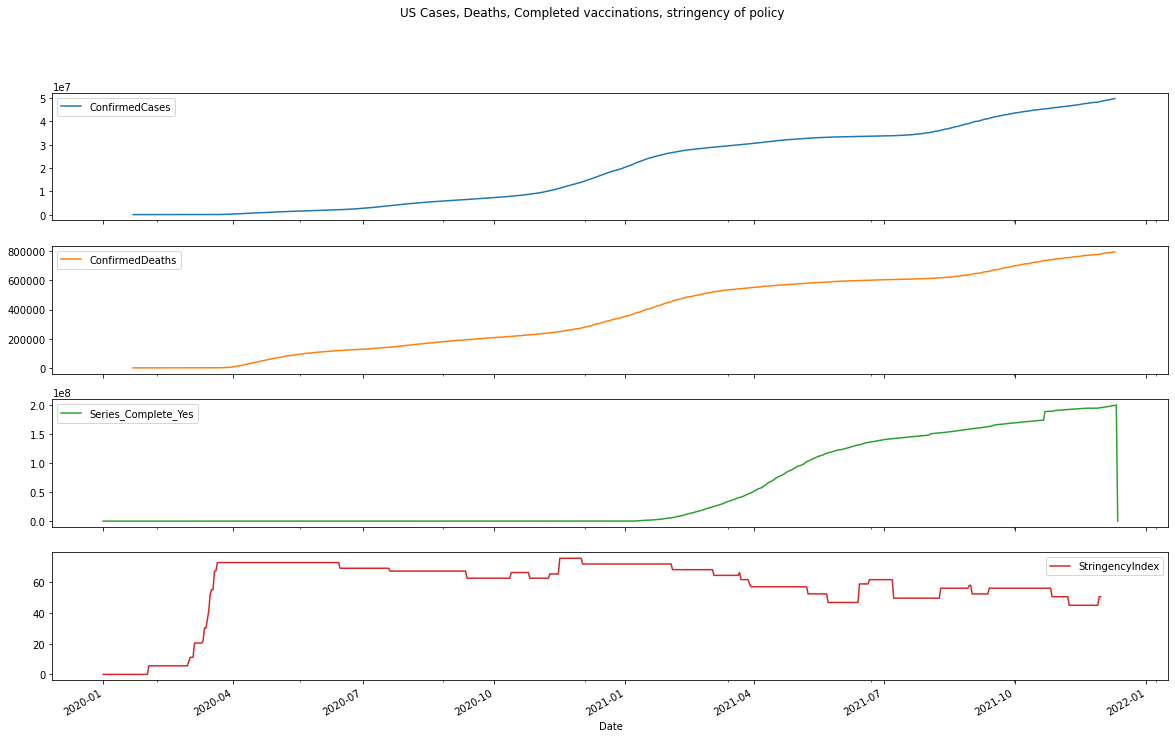

In [17]:
data_us_states['US'].plot(subplots=True,y=['ConfirmedCases','ConfirmedDeaths','Series_Complete_Yes','StringencyIndex'],
    title='US Cases, Deaths, Completed vaccinations, stringency of policy', figsize=(20,12))
buffer = data_us_states['US']

After ploting out the four values, I can see some important time series that the policies are chaning. The first one is between March and April, 2020. We can see that the stringency is suddently increasing. The second one is between July and November. Although the number of cases and deaths was steadily increasing, the strigency of policies was decreasing. As a result, it was a incredible increase around December 2020. The third one is between February and July 2021. As the number of vaccinations increasing, the cases and deaths grew slower and the stringency of policies was decreasing. The fourth one is around December 2021. There is a increasing trend of the cases and stringency of policies.

Then, I want to take a closer look at the data to see what is the more exact date of the change. What is the related information in the timeline at those periods. I plot the four lines animation to show the change of date directly.

In [18]:
from IPython.display import HTML
buffer = buffer[['ConfirmedCases','ConfirmedDeaths','Series_Complete_Yes','StringencyIndex']]
buffer.dropna(inplace=True)
buffer.sort_index(inplace=True)
plots = []
for i in buffer:
    plots.append(buffer[i].plot_animated(kind='line',steps_per_period=1,period_length=10,period_fmt='%Y-%m-%d',fixed_max=True))
figs = plt.Figure()
figs.set_dpi(144)
gs = figs.add_gridspec(len(plots),1,hspace=0.5)
f1_ax = []
for i in range(len(plots)):
    f1_ax.append(figs.add_subplot(gs[i,0]))
    plots[i].ax = f1_ax[i]
pandas_alive.animate_multiple_plots(filename='US_line.mp4',plots=plots, custom_fig=figs, enable_progress_bar=True)

Generating LineChart, plotting ['ConfirmedCases']
Generating LineChart, plotting ['ConfirmedDeaths']
Generating LineChart, plotting ['Series_Complete_Yes']
Generating LineChart, plotting ['StringencyIndex']


In [19]:
from IPython.display import Video
Video("US_line.mp4")

Through the animation, I can the the first important date is around March 10. Looking it up in the timeline data, we can see on March 10 WHO announced that COVID-10 a pandemic. On March 13 "President Donald J. Trump declares a nationwide emergency". On March 15 US states started shuting down. As a result, the stringency increased rapidly.

try ploting all the data in the US animatively. We needs several dataFrames, which have states as columns and date as index. Each dataFrame represents an element I want to plot(ConfirmedCases, ConfirmedDeaths etc.).

In [20]:
Series_df = pd.DataFrame(index=buffer.index)
US_Cases_df = pd.DataFrame(index=buffer.index)
US_Deaths_df = pd.DataFrame(index=buffer.index)
US_Stringency_df = pd.DataFrame(index=buffer.index)
for state, df in US_data[['State','ConfirmedCases','ConfirmedDeaths','Series_Complete_Yes','StringencyIndex']].groupby('State'):
    df.sort_index(inplace=True)
    if state != 'US':
        df.fillna(0,inplace=True)
        Series_df[state] = df['Series_Complete_Yes']
        US_Cases_df[state] = df['ConfirmedCases']
        US_Deaths_df[state] = df['ConfirmedDeaths']
        US_Stringency_df[state] = df['StringencyIndex']

series_chart = Series_df.plot_animated(steps_per_period=1,period_length=15,period_fmt='%Y-%m-%d',dpi=144,n_visible=25,figsize=(15,7.5),orientation='v',writer='ffmpeg',bar_label_size=5)
cases_chart = US_Cases_df.plot_animated(steps_per_period=1,period_length=15,period_fmt='%Y-%m-%d',dpi=300,n_visible=25,figsize=(20,10),orientation='v',writer='ffmpeg',bar_label_size=5)
deaths_chart = US_Deaths_df.plot_animated(steps_per_period=1,period_length=15,period_fmt='%Y-%m-%d',dpi=144,n_visible=25,figsize=(15,7.5),orientation='v',writer='ffmpeg',bar_label_size=5)
strigency_chart = US_Stringency_df.plot_animated(steps_per_period=1,period_length=15,period_fmt='%Y-%m-%d',dpi=144,figsize=(15,7.5),n_visible=30,orientation='v',bar_label_size=5)

Generating BarChartRace, plotting ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'FM', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MH', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'PW', 'RI', 'SC', 'SD', 'TN', 'TX', 'UNK', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY']
Generating BarChartRace, plotting ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'FM', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MH', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'PW', 'RI', 'SC', 'SD', 'TN', 'TX', 'UNK', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY']
Generating BarChartRace, plotting ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'FM', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MH', 'MI', 'MN', 'MO',

In [21]:
minx, miny, maxx, maxy = -2e7, 0, -.5e7, 1.2e7
states_map = geopandas.read_file('cb_2018_us_state_500k.shp')
# states_map = geopandas.read_file('tl_2017_us_state.shp')
states_map = states_map.to_crs(epsg=3081)
# remove GU MP NV AS HI
states_map = states_map[states_map.STUSPS != 'GU']
states_map = states_map[states_map.STUSPS != 'MP']
states_map = states_map[states_map.STUSPS != 'NV']
states_map = states_map[states_map.STUSPS != 'AS']
states_map = states_map[states_map.STUSPS != 'HI']
states_map.set_index('STUSPS',inplace=True)

In [22]:
US_cases_gdf = US_Cases_df.T
US_Deaths_gdf = US_Deaths_df.T
US_Stringency_gdf = US_Stringency_df.T
US_series_gdf = Series_df.T
dict = states_map['geometry'].to_dict()
US_cases_gdf['geometry'] = US_cases_gdf.index.map(dict)
US_Deaths_gdf['geometry'] = US_Deaths_gdf.index.map(dict)
US_Stringency_gdf['geometry'] = US_Stringency_gdf.index.map(dict)
US_series_gdf['geometry'] = US_series_gdf.index.map(dict)
US_cases_gdf = US_cases_gdf[US_cases_gdf['geometry'].notna()]
US_Deaths_gdf = US_Deaths_gdf[US_Deaths_gdf['geometry'].notna()]
US_Stringency_gdf = US_Stringency_gdf[US_Stringency_gdf['geometry'].notna()]
US_series_gdf = US_series_gdf[US_series_gdf['geometry'].notna()]
US_cases_gdf = geopandas.GeoDataFrame(US_cases_gdf,crs=states_map.crs,geometry=US_cases_gdf['geometry'])
US_Deaths_gdf = geopandas.GeoDataFrame(US_Deaths_gdf,crs=states_map.crs,geometry=US_Deaths_gdf['geometry'])
US_Stringency_gdf = geopandas.GeoDataFrame(US_Stringency_gdf,crs=states_map.crs,geometry=US_Stringency_gdf['geometry'])
US_series_gdf = geopandas.GeoDataFrame(US_series_gdf,crs=states_map.crs,geometry=US_series_gdf['geometry'])
US_cases_gdf.sort_index(inplace=True)
US_Deaths_gdf.sort_index(inplace=True)
US_Stringency_gdf.sort_index(inplace=True)
US_series_gdf.sort_index(inplace=True)
geo_stri = US_Stringency_gdf.plot_animated(steps_per_period=1,period_length=15,period_fmt='%Y-%m-%d',dpi=144,cmap='Oranges', fixed_max=False,title='strigency',figsize=(20,12),writer='ffmpeg')
figs = plt.Figure()
figs.set_dpi(200)
figs.set_size_inches(10,5.625)
gs = figs.add_gridspec(2,2)
f2_ax1 = figs.add_subplot(gs[0,0])
cases_chart.ax = f2_ax1
cases_chart.ax.set_title('Confirmed Cases')
f2_ax2 = figs.add_subplot(gs[0,1])
deaths_chart.ax = f2_ax2
deaths_chart.ax.set_title('Confirmed Deaths')
f2_ax3 = figs.add_subplot(gs[1,0])
series_chart.ax = f2_ax3
series_chart.ax.set_title('Series Complete')
f2_ax4 = figs.add_subplot(gs[1,1])
f2_ax4.set_title('strigency')
geo_stri.ax = f2_ax4
plots = [cases_chart,deaths_chart,series_chart,geo_stri]
# pandas_alive.animate_multiple_plots(filename='All_states_bar.mp4',plots=plots, custom_fig=figs,adjust_subplot_hspace=.1,adjust_subplot_wspace=.1)

In [23]:
Video('All_states_bar.mp4')

In [24]:
# US_cases_gdf.plot_animated(filename='geoCases.mp4',steps_per_period=1,period_length=10,period_fmt='%Y-%m-%d',cmap="Reds",dpi=144, fixed_max=True)
# US_Deaths_gdf.plot_animated(filename='geoDeaths.mp4',steps_per_period=1,period_length=10,period_fmt='%Y-%m-%d',cmap="Reds",dpi=144, fixed_max=True)
# US_Stringency_gdf.plot_animated(filename='geoStringency.mp4',steps_per_period=1,period_length=10,period_fmt='%Y-%m-%d',cmap="Reds",dpi=144, fixed_max=True)
# US_series_gdf.plot_animated(filename='geoSeries.mp4',steps_per_period=1,period_length=10,period_fmt='%Y-%m-%d',cmap="Reds",dpi=144, fixed_max=True)


In [25]:
Video('geoCases.mp4')

In [26]:
Video('geoDeaths.mp4')

In [27]:
Video('geoStringency.mp4')

In [28]:
Video('geoSeries.mp4')

In [29]:
# plots = []
# for i in [US_cases_gdf,US_Deaths_gdf,US_Stringency_gdf,US_series_gdf]:
#     plots.append(i.plot_animated(filename='geoCases.mp4',basemap_format={'source':cx.providers.Stamen.Terrain},steps_per_period=1,period_length=5,period_fmt='%Y-%m-%d',cmap="Reds",enable_progress_bar=True,dpi=144, fixed_max=True))
# figs = plt.Figure()
# figs.set_dpi(144)
# gs = figs.add_gridspec(len(plots),1,hspace=0.5)
# f1_ax = []
# name = ['Cases','Deaths','Stringency','Series']
# for i in range(len(plots)):
#     f1_ax.append(figs.add_subplot(gs[i,0]))
#     f1_ax[i].set_xlim(-1.5e7,-.4e7)
#     f1_ax[i].set_ylim(0,.8e7)
#     f1_ax[i].set_title(name[i])
#     plots[i].ax = f1_ax[i]
# pandas_alive.animate_multiple_plots(filename='US_geo.mp4',plots=plots, custom_fig=figs, enable_progress_bar=True)

## Conclusion